In [5]:
import warnings
from os import path

import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import variation
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# %matplotlib inline


# General Data Description

Authors: Magdalena Oska (174426), Pawel Okrutny (175689), Michal Radziwanowski (163220)

### Dataset

A simulated data set containing information on four hundred customers. The aim here is to predict which customers will 
default on their credit card debt. Credit data set records balance (average credit card debt for a number of individuals) as well as several quantitative predictors: age, cards (number of credit cards), education (years of education), income (in thousands of dollars), limit (credit limit), and rating (credit rating).

> taken from "An Introduction to Statistical Learning, with applications in R" (Springer, 2013) 
> with permission from the authors: G. James, D. Witten,  T. Hastie and R. Tibshirani

`Income`: Annual income in $1,000's

`Limit`: Credit limit

`Rating`: Credit rating

`Cards`: Number of credit cards

`Age`: Age in years

`Education`: Number of years of education

`Gender`: A factor with levels `Male` and `Female`

`Student`: A factor with levels `No` and `Yes` indicating whether the individual was a student

`Married`: A factor with levels `No` and `Yes` indicating whether the individual was married

`Ethnicity`: A factor with levels `African American`, `Asian`, and `Caucasian` indicating the individual's ethnicity

`Balance`: Average monthly credit card balance in $



In [6]:
source_dir = '../data'
source_file = 'credit.csv'

def read_csv(source):
    return pd.read_csv(path.join(source_dir, source), low_memory=False)

data = read_csv(source_file)
print(f"shape: {data.shape}")
data.head()

shape: (400, 12)


,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


### Prepare data


#### Drop null and column 'Unnamed: 0' that is the index column from dataset

In [7]:
data.dropna(inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)
print(f"shape: {data.shape}")
data.head()

shape: (400, 11)


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


There were no rows with empty data.


#### Check column types

In [8]:
data.dtypes


Income       float64
Limit          int64
Rating         int64
Cards          int64
Age            int64
Education      int64
Gender        object
Student       object
Married       object
Ethnicity     object
Balance        int64
dtype: object

Rename all columns to lowercase and set categorical columns to 'category':

In [9]:
data.rename(columns={n: n.lower() for n in data.columns}, inplace=True)
categorical_columns = [
    'gender',
	'student',
	'married',
    'ethnicity'
]
for name in categorical_columns:
	data[name] = data[name].astype('category')
print(data.dtypes)
data.head()


income        float64
limit           int64
rating          int64
cards           int64
age             int64
education       int64
gender       category
student      category
married      category
ethnicity    category
balance         int64
dtype: object


,income,limit,rating,cards,age,education,gender,student,married,ethnicity,balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


### Income groups

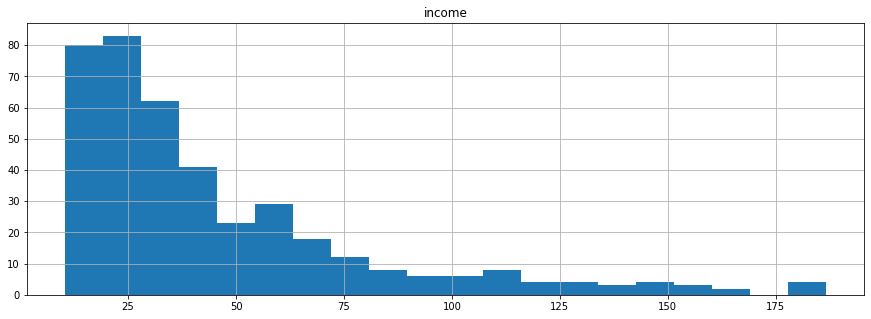

In [10]:
_ = data.hist(column='income', bins=20, figsize=(15,5))


_Frequency of income. The vast majority of customers find in bins with smaller income._

Add `Income Group` column with categories:

- `The Poor`: income up to \$18,000
- `Working Class`: income above \\$18,000 up to \$60,000 
- `Middle Class`: income above \\$60,000 up to \$100,000 
- `The Rich`: income above \$100,000

In [11]:
income_groups = {
 	'The Poor': 0, # - 18
	'Working Class': 18, # - 50
	'Lower-Middle Class': 30, # - 100
	'Upper-Middle Class': 50, # - 100
	'The Rich': 100, # - ...
}
data['income_group'] = pd.cut(data['income'], list(income_groups.values()) + [data['income'].max()], right=False, labels=income_groups.keys())
data.head()


,income,limit,rating,cards,age,education,gender,student,married,ethnicity,balance,income_group
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,The Poor
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,The Rich
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,The Rich
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,The Rich
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,Upper-Middle Class


Rows per `Income Group`

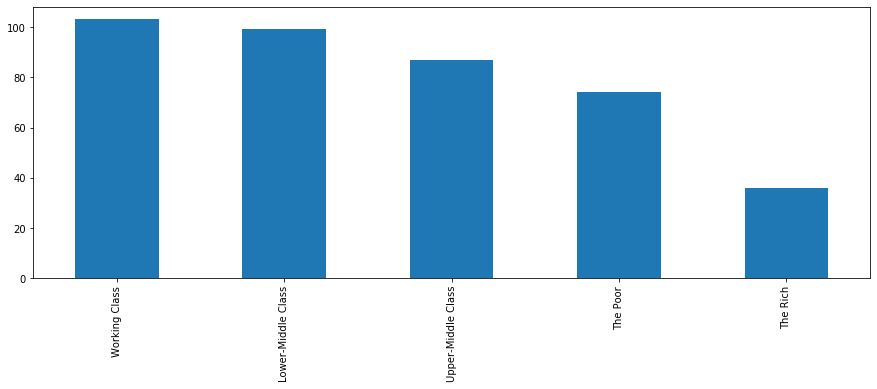

In [12]:
_ = data['income_group'].value_counts().plot(kind='bar', figsize=(15,5))


_Number of customers in every income group. The number of customers in the working class and lower-middle class is similar. The two extreme groups (the poor and the reach) have the less representatives._

`Income` histogram by `Income Group`

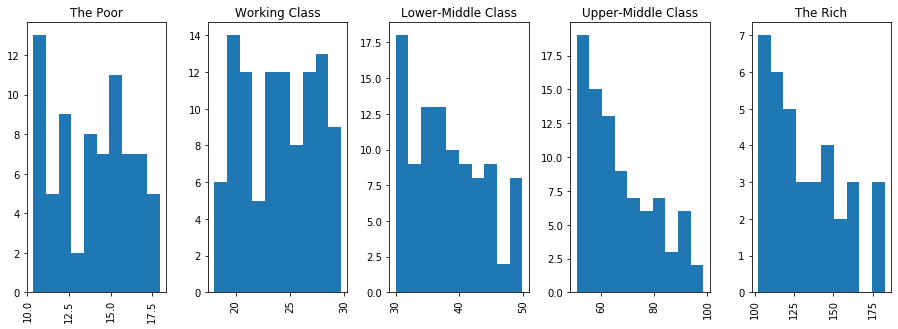

In [13]:
_ = data.hist(column='income', by='income_group', layout=(1, 5), figsize=(15,5))


_It can be seen that the majority of customers of the upper-middle class has income closer to the lower range._

`Balance` boxplot by `Income Group`

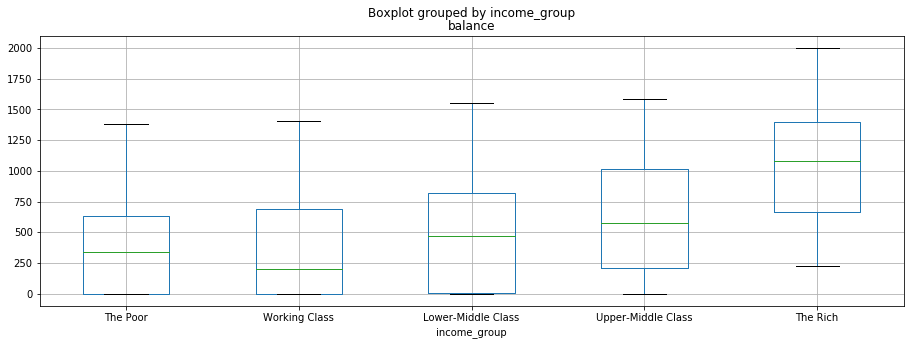

In [14]:
_ = data.boxplot(column='balance', by='income_group', figsize=(15,5))


_First quartile for first three groups balance is around \\$0, but the third quartile rises with the group. Also none of the customers from the Rich group has avarege balance equal to \\$0 and half of these customers have balance beetwen ~700-1400._

`Age` boxplot by `Income Group`

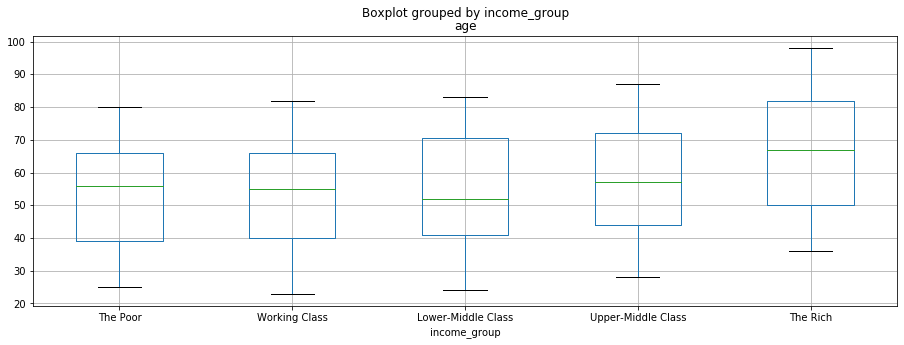

In [15]:
_ = data.boxplot(column='age', by='income_group', figsize=(15,5))


_The Rich group consists of rather older clients. First three group are quite similar, but interesting fact is that the median of age is lower in Lower-Middle Class than in Working Class or the Poor._

`Education` boxplot by `Income Group`

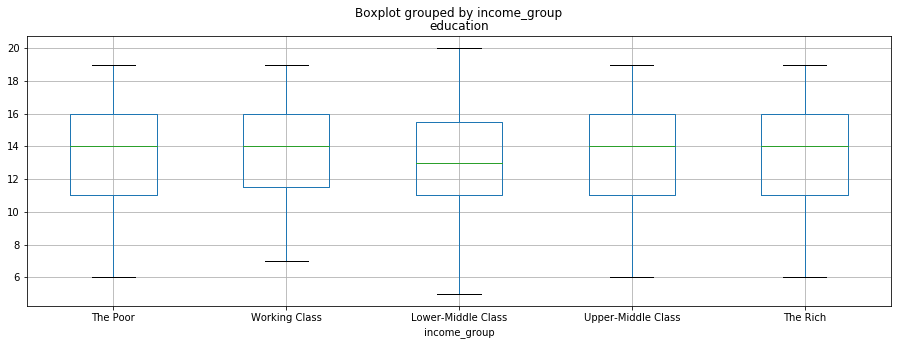

In [16]:
_ = data.boxplot(column='education', by='income_group', figsize=(15,5))


_Education years for all groups have similar distribution for all groups. The lower-middle class has the widest range and also median is one year lower than for other groups._

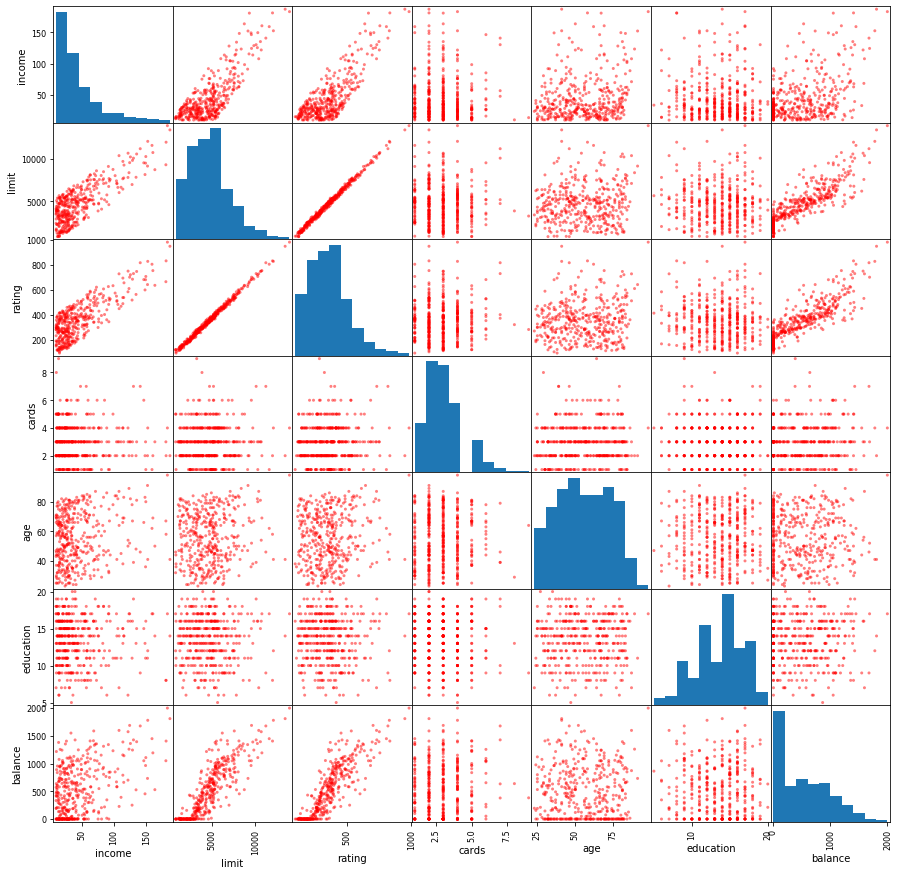

In [17]:
_ = pd.plotting.scatter_matrix(data, color="red", figsize=(15, 15))


_Correlation observations:_
- strong positive correlation between rating and limit.
- some positive correlation beetween limit and income, rating and income, limit and balance, rating and balance.

### Analyze data to prepare model


In [18]:
data.describe()

,income,limit,rating,cards,age,education,balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 12 columns):
income          400 non-null float64
limit           400 non-null int64
rating          400 non-null int64
cards           400 non-null int64
age             400 non-null int64
education       400 non-null int64
gender          400 non-null category
student         400 non-null category
married         400 non-null category
ethnicity       400 non-null category
balance         400 non-null int64
income_group    399 non-null category
dtypes: category(5), float64(1), int64(6)
memory usage: 27.5 KB


Age histograms: all and by gender.

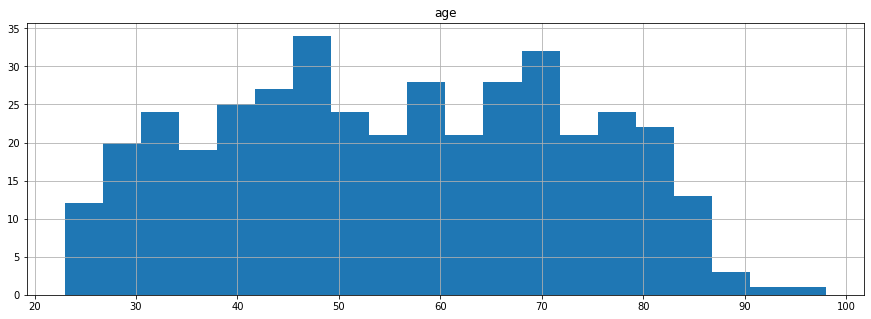

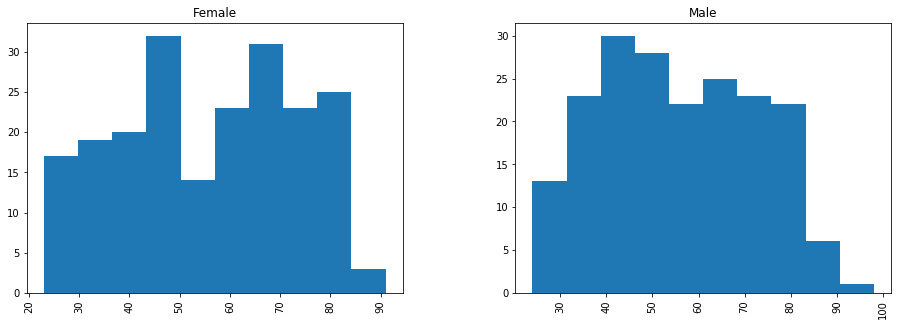

In [20]:
_ = data.hist(column='age', bins=20, figsize=(15,5))
_ = data.hist(column='age', bins=10, by='gender', layout=(1,2), figsize=(15,5))


_Frequency of age is rather evenly distributed_

Education histograms: all, by gender and by ethencity.

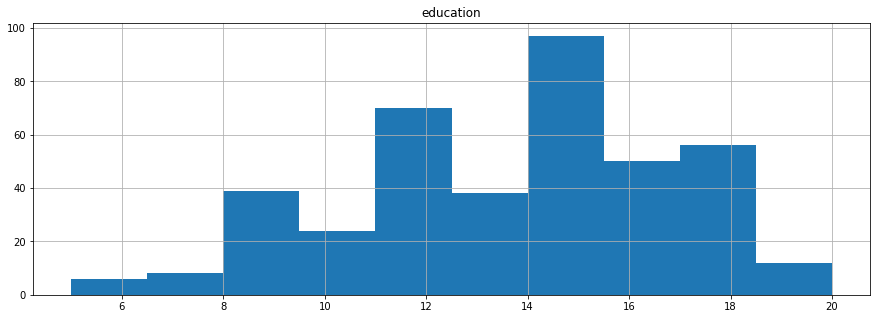

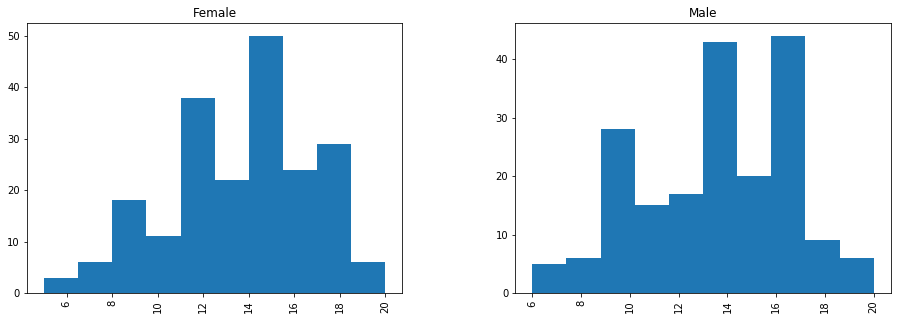

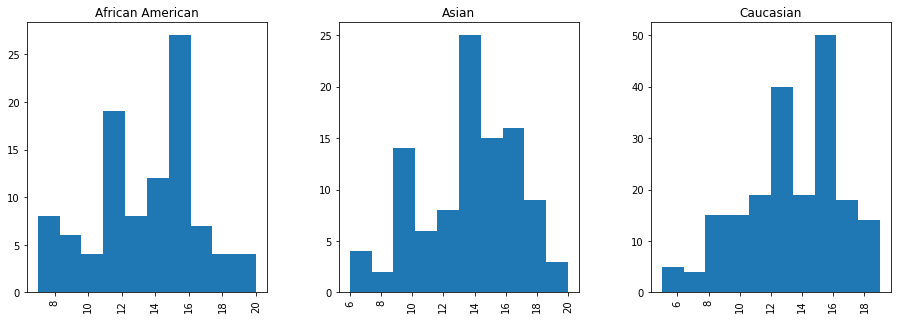

In [21]:
_ = data.hist(column='education', figsize=(15,5))
_ = data.hist(column='education', by='gender', layout=(1,2), figsize=(15,5))
_ = data.hist(column='education', by='ethnicity', layout=(1,3), figsize=(15,5))


Ethenicity, gender and married status grouped by student status.

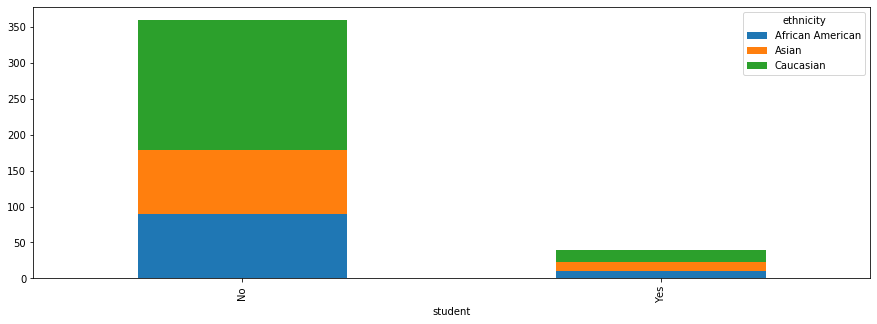

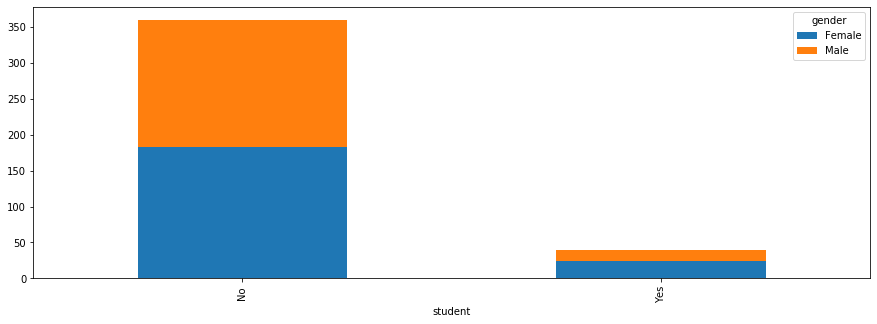

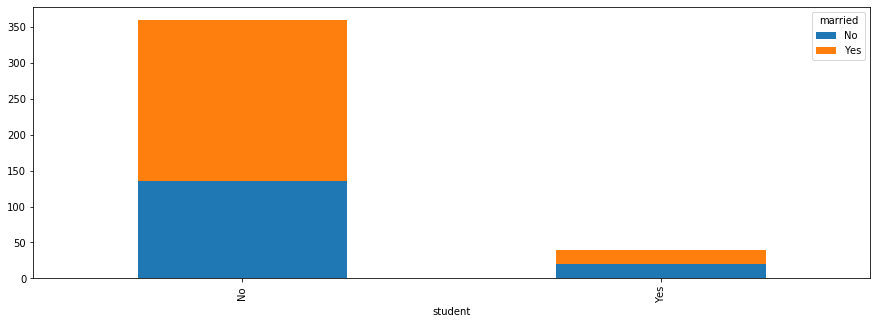

In [22]:
_ = data.groupby('student')['ethnicity'].value_counts().unstack(1).plot(kind='bar', stacked=True, figsize=(15,5))
_ = data.groupby('student')['gender'].value_counts().unstack(1).plot(kind='bar', stacked=True, figsize=(15,5))
_ = data.groupby('student')['married'].value_counts().unstack(1).plot(kind='bar', stacked=True, figsize=(15,5))


_Around half of the students in the sample are Caucasian. Female/Male proporion are almost equal. Most of the students are married._

Pie plots with proportions of ethnicity dependent on marriage status and income group.

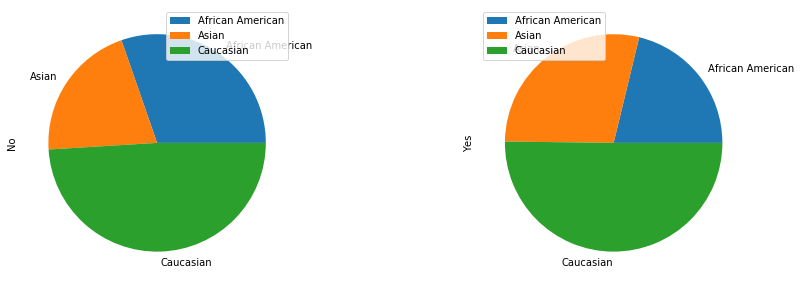

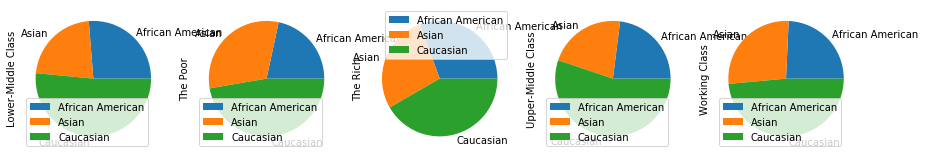

In [23]:
_ = data.groupby('ethnicity')['married'].value_counts().unstack(1).plot(kind='pie', subplots=True, figsize=(15,5))
_ = data.groupby('ethnicity')['income_group'].value_counts().unstack(1).plot(kind='pie', subplots=True, figsize=(15,10))


_Caucasian marriage status is similar but proportionally more Asians in the sample are married than African American._  
_The most evenly distributed by ethenicity income group is the Rich. Asians occupy the largest percentage in the Poor group._

Pie plots with proportions of income group dependent on ethinicity, gender and marriage status.

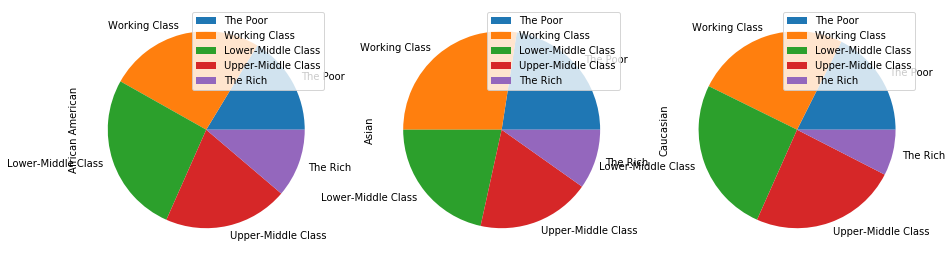

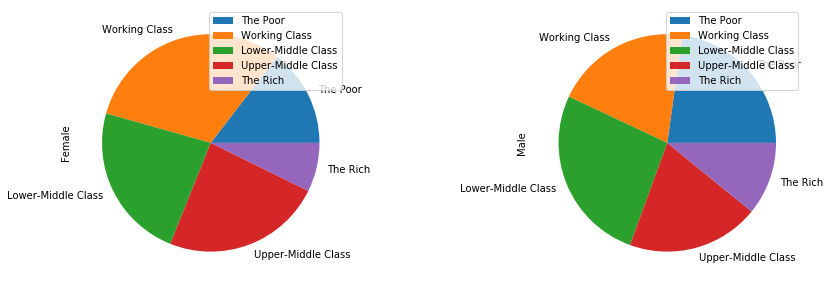

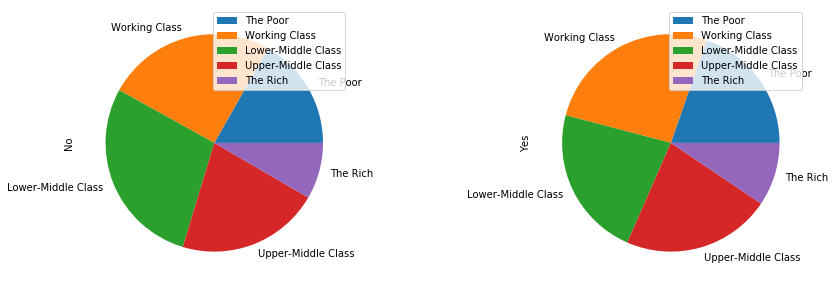

In [24]:
_ = data.groupby('income_group')['ethnicity'].value_counts().unstack(1).plot(kind='pie', subplots=True, figsize=(15,5))
_ = data.groupby('income_group')['gender'].value_counts().unstack(1).plot(kind='pie', subplots=True, figsize=(15,5))
_ = data.groupby('income_group')['married'].value_counts().unstack(1).plot(kind='pie', subplots=True, figsize=(15,5))

_For African American and Caucasian share between lower-middle class and working class is similar. Asians have largest percentage of working class. The Rich group income occupy the largest percentage in African American distribution._  
_Between Female and Male can notice that the Poor group occupy more share in Male plot and working class is greater in Female._  
_Marriage statuses are similarly distribiuted. A little bit more customers in marriage are in upper-middle class and not married customers have bigger share in lower-middle class._

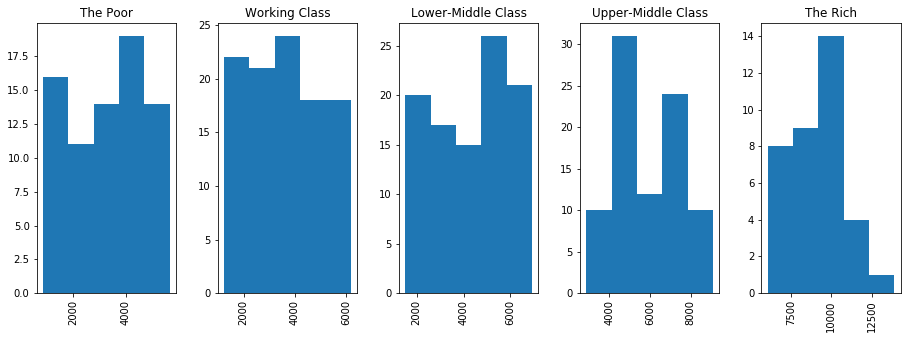

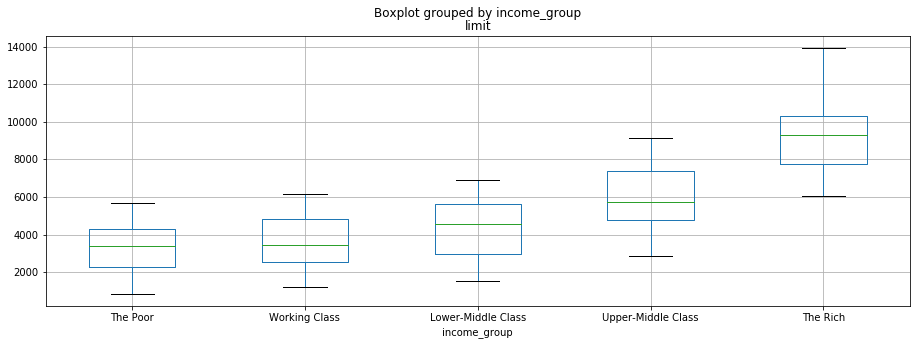

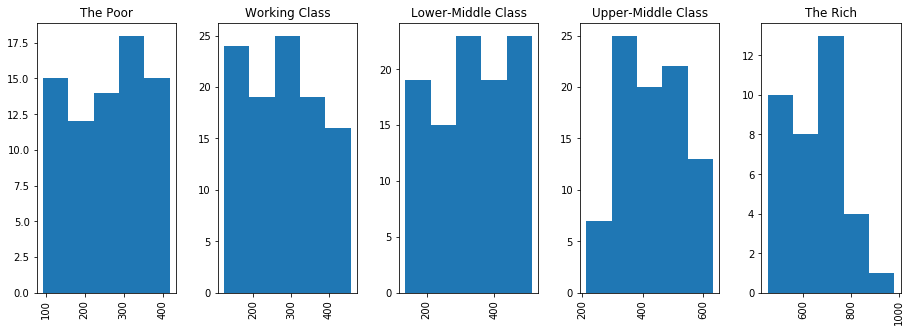

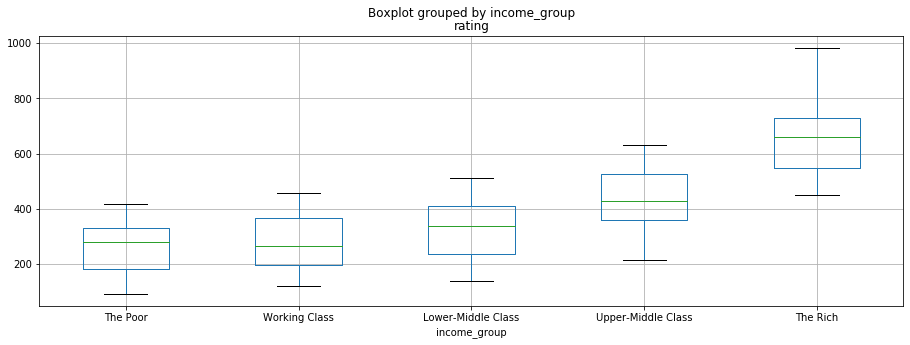

In [27]:
for col in ["limit", "rating"]:
	_ = data.hist(column=col, by="income_group", bins=5, layout=(1,5), figsize=(15,5))
	_ = data.boxplot(column=col, by="income_group", figsize=(15,5))

_Limit and rating attributes have very similar box plots. It is visible that the Rich group has much higher values for these two attributes than the rest of the groups. Also Upper-Middle Class stand outs a little bit more from first three groups._

Coefficient of variation (determine how much the group is differentiated from certain attributes):

In [ ]:
columns = ["income", "limit", "rating", "cards", "age", "education", "balance"]
values = [variation(data[x]) for x in columns]
plt.scatter(columns, values)

_Customers are the most diverse in terms of balance and income, and the least in terms of years of education._